In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [44]:
df = pd.read_csv('data/electricity-consumption.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.set_index('Datetime')

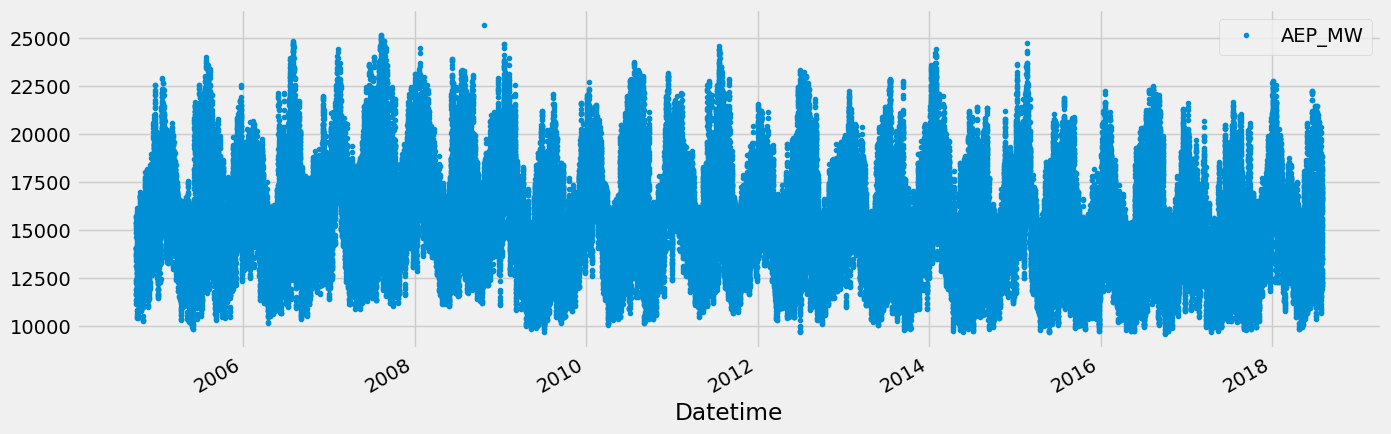

In [45]:
df.plot(style='.',
        figsize=(15, 5))
plt.show()

# Time Series Cross Validation

In [51]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365)
df = df.sort_index()

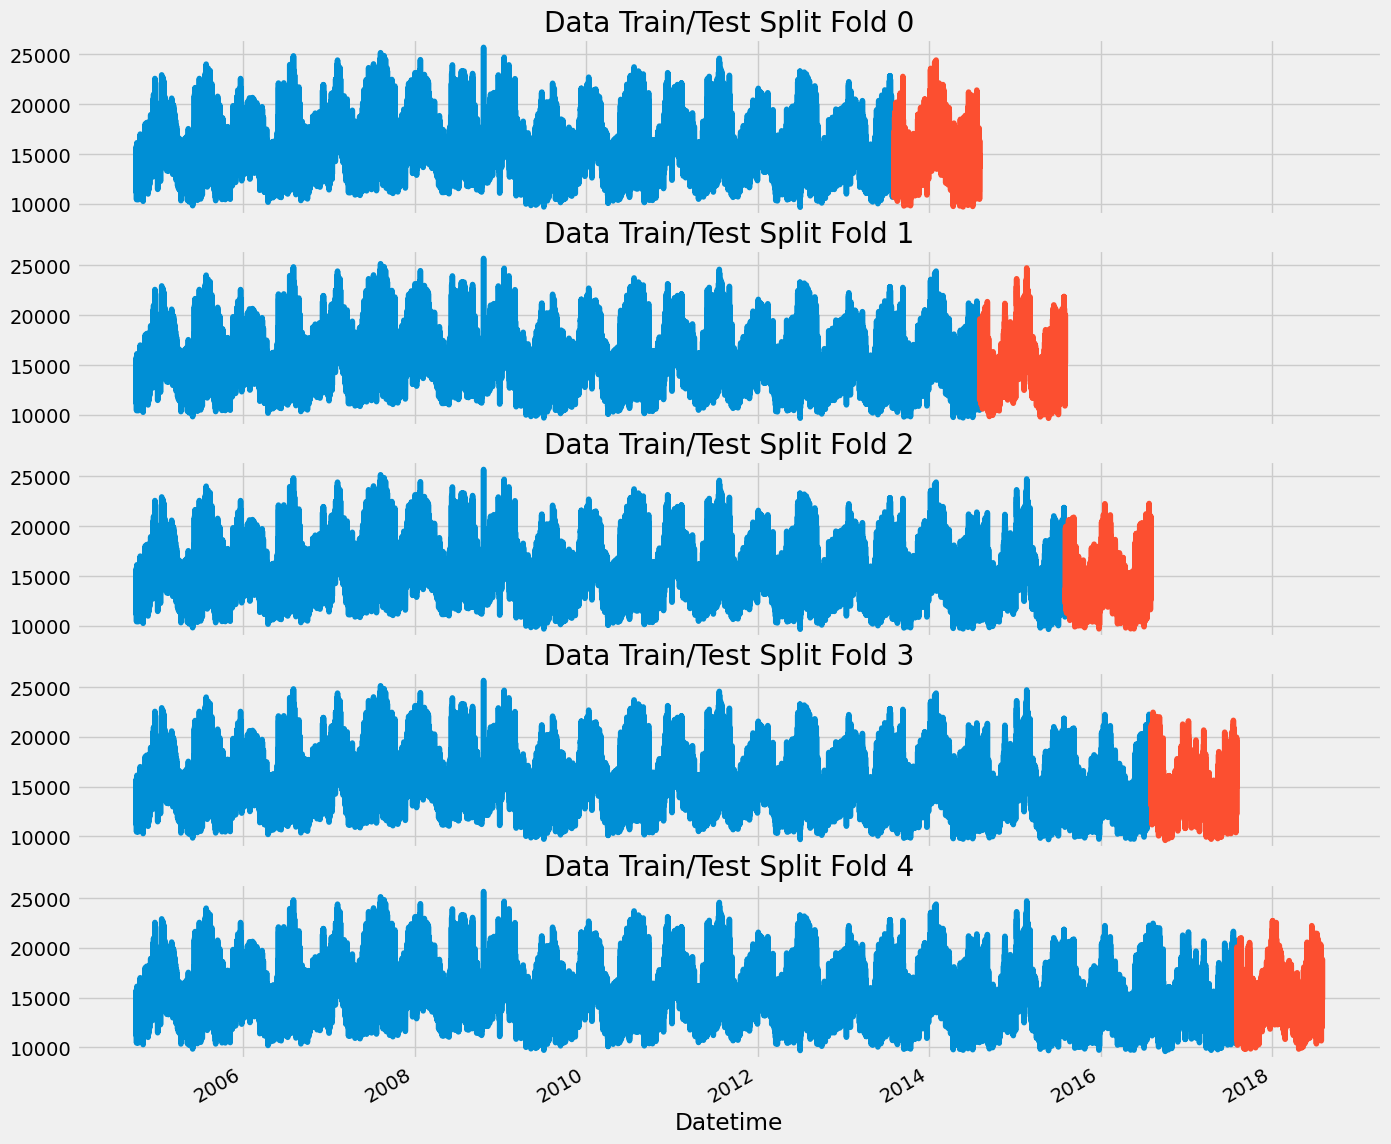

In [52]:
f, ax = plt.subplots(5, 1, figsize=(15, 15), sharex=True)
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['AEP_MW'].plot(ax=ax[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['AEP_MW'].plot(ax=ax[fold], label='Test Set')
    fold += 1
plt.show()

In [53]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [64]:
def add_lags(df):
    target_map = df['AEP_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

df = add_lags(df)

df.dropna(inplace=True)

In [67]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

Fold scores:[1563.3936452394594, 1465.3086840140002, 1613.8525668068944, 1700.708201148854, 1730.9541737690574]


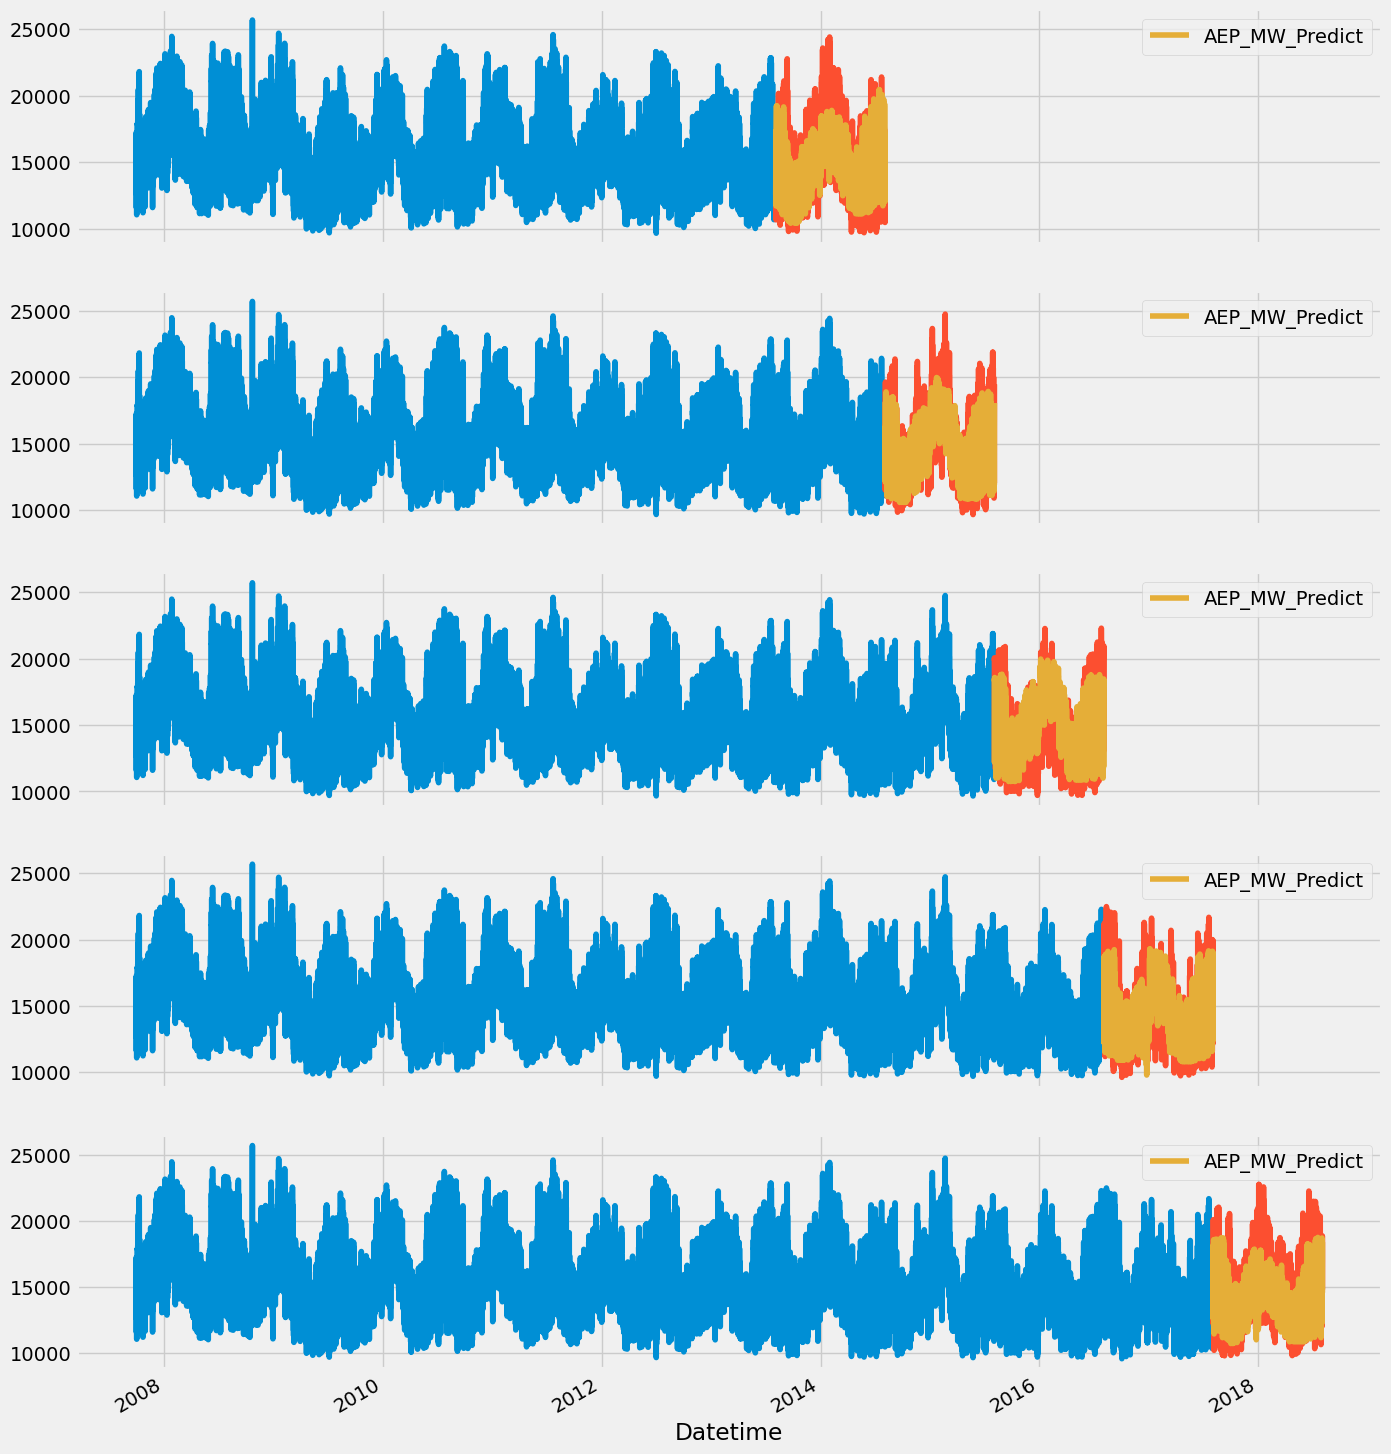

In [102]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

f, ax = plt.subplots(5, 1, figsize=(15, 20), sharex=True)

fold = 0
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['AEP_MW'].plot(ax=ax[fold])
    test['AEP_MW'].plot(ax=ax[fold])

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'AEP_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    model = GradientBoostingRegressor()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred = pd.DataFrame({'AEP_MW_Predict':y_pred}, index=y_test.index)
    y_pred.plot(ax=ax[fold])
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

    fold = fold + 1

print(f'Fold scores:{scores}')
plt.show()

# Predicting the future

In [96]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [97]:
future_w_features = df_and_future.query('isFuture').copy()

In [100]:
future_w_features = future_w_features.loc[future_w_features[FEATURES].isna().any(axis=1) == False]

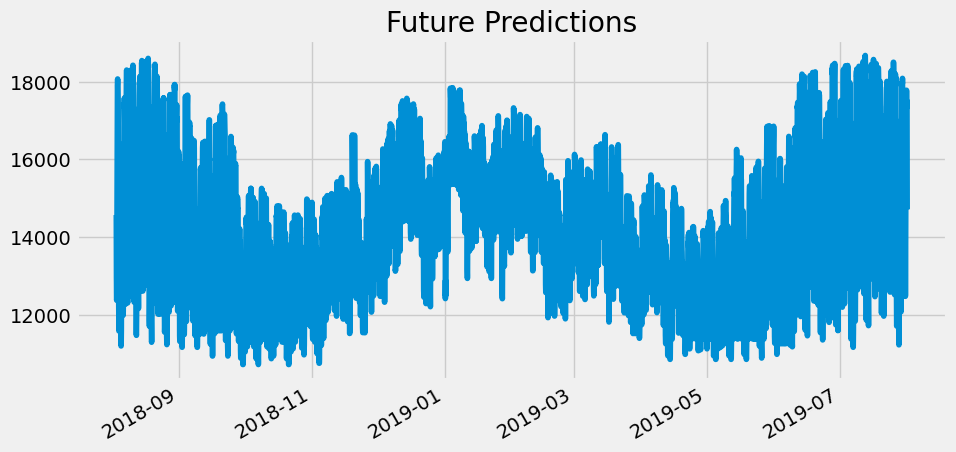

In [101]:
future_w_features['pred'] = model.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               title='Future Predictions')
plt.show()